In [1]:
import numpy as np
import pickle

from transformers import RobertaForMaskedLM

import nlpsig

from joblib import Parallel, delayed, cpu_count
import roughpy as rp

from load_data import seed, english_train, corpus_sample_df

import time
from signature_mahalanobis_knn import SignatureMahalanobisKNN
from signature_mahalanobis_knn.utils import (
    compute_auc_given_dists,
    plot_cdf_given_dists,
)

loading in english_train from data/corpus.pkl
loading in english_train from data/english_train.pkl
loading in corpus_sample_df from data/corpus_sample.pkl


# Anomaly Detection task

In natural language processing (NLP) tasks, we often are dealing with high dimensional streams of data. Neural network architectures known as Transformers have been shown to be very effective in NLP tasks, and we can use these to obtain high dimensional streams of embeddings for words/tokenised text. In this notebook, we will look at how we can use path signature techniques to analyse these high dimensional streams of embeddings. In particular, we will look at how we can perform outlier detection on the path signatures of the embeddings obtained from a pre-trained Transformer. 

In particular, we consider the task of determining whether a word is an english word or not by using the path signature of the stream of _character_ embeddings of the word. That is, each word is represented as a stream of character embeddings. We do this by training a Transformer model (from scratch) on a _masked language modelling_ task (or _Cloze_ task) as described in [[1]](https://arxiv.org/abs/1810.04805) using a corpus of english words, and then use this model to obtain a stream of (character) embeddings for a sample of (english and non-english) words. Path signature techniques are applied to analyse the streams of embeddings and finally we attempt to detect the non-english words as outliers in the space of path signatures.

Since we are dealing with high dimensional streams of data, we will use a dimension reduction technique to reduce the dimension of the embeddings before computing the path signature. We will look at how we can perform outlier detection on the path signatures of the dimension-reduced embeddings.

The pipeline for this task is as follows:
1. Train a Transformer model on a masked language modelling task using a corpus of english words.
2. Obtain a stream of character embeddings for a sample of english and non-english words using the trained model (note that we ensure that the english words in this sample are not in the training corpus to pre-train the Transformer).
    - The english words in this sample are our _inlier_ class while the non-english words are our _outlier_ class in this example.
3. Perform dimension reduction on the streams of embeddings.
4. Compute the path signature of the dimension-reduced embeddings.
5. Perform outlier detection on the path signatures to detect the non-english words.

In this notebook, we illustrate how we can use the [`nlpsig`](https://github.com/datasig-ac-uk/nlpsig) package to utilise transformers in order to obtain streams of high dimensional embeddings, which can then be analysed using path signature techniques.

Furthermore, we utilise the [`signature_mahalanobis_knn`](https://github.com/datasig-ac-uk/signature_mahalanobis_knn) library to perform outlier detection on the path signatures. Full details of our approach can be found in [[2]](https://arxiv.org/abs/2006.03487) _Dimensionless Anomaly Detection on Multivariate Streams with Variance Norm and Path Signature_ by Zhen Shao, Ryan Sze-Yin Chan, Thomas Cochrane, Peter Foster, Terry Lyons.

## Language dataset

In the `data/` folder, we have several text folders of words from different languages:
- `wordlist_de.txt`: German words
- `wordlist_en.txt`: English words
- `wordlist_fr.txt`: French words
- `wordlist_it.txt`: Italian words
- `wordlist_pl.txt`: Polish words
- `wordlist_sv.txt`: Swedish words

We additionally have a `alphabet.txt` file which just stores the alphabet characters ('a', 'b', 'c', ...).

The task is to split the words into its individual characters and to obtain an embedding for each of them. We can represent a word by a path of its character embeddings and compute its path signature to use as features in predicting the language for which the word belongs.

Here we look at obtaining embeddings using a Transformer model.

## Prepare training data and test data

We prepare our data in the [`language_dataset_anomalies_data.ipynb`](language_dataset_anomalies_data.ipynb) notebook and load in our data using the [`load_data.py`](load_data.py) script, so look in there for more details.

Our test data will consist a sample of 10000 english words and 10000 non-english words (2000 from each of the remaining languages). We will use the remaining english words as our training data to train the Transformer model and as our corpus of "normality":

In [2]:
english_train

,word,language
0,knots,en
1,stalemating,en
2,whoops,en
3,implantation,en
4,levers,en
...,...,...
70610,forcefulness,en
70611,fat,en
70612,creakier,en
70613,ramming,en


To make the dataset bit more manageable, we take a sample of each of the languages. In our resulting corpus, we have an equal amount of english (inliers) and non-english words (outliers):

In [3]:
corpus_sample_df["language"].value_counts()

language
en    10000
de     2000
fr     2000
it     2000
pl     2000
sv     2000
Name: count, dtype: int64

In [4]:
corpus_sample_df.head()

,word,language
0,abblendet,de
1,bestechendes,de
2,narrensicheren,de
3,inakzeptable,de
4,abbestelle,de


## Training a language model

We want to train a masked language model for our corpus of English words. In particular, we mask out particular letters and ask our model to try predict the masked letter.
We do this using the [`nlpsig.TextEncoder`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder) class which provides a wrapper around the [`transformers`](https://huggingface.co/docs/transformers/index) library, and have done this in a separate notebook - see [`train_english_char_bert.ipynb`](train_english_char_bert.ipynb). 

In that notebook, we trained a [Roberta](https://huggingface.co/docs/transformers/model_doc/roberta) language model described in [[3]](https://arxiv.org/abs/1907.11692), and uploaded the model to the [Huggingface model hub](https://huggingface.co/rchan26/english-char-roberta). We can easily load this model in.

In [5]:
model_name = "rchan26/english-char-roberta"

In [6]:
english_train_encoder = nlpsig.TextEncoder(
    df=english_train,
    feature_name="word",
    model_name=model_name,
)

In [7]:
english_train_encoder.load_pretrained_model()

[INFO] By default, `.load_pretrained_model()` uses `AutoModel` to load in the model. If you want to load the model for a specific task, reset the `.model` attribute.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaModel were not initialized from the model checkpoint at rchan26/english-char-roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
english_train_encoder.model

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(57, 768, padding_idx=1)
    (position_embeddings): Embedding(52, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dr

However, by default, the [`nlpsig.TextEncoder.load_pretrained_model`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.load_pretrained_model) method will use the [`transformers.AutoModel.from_pretrained`](https://huggingface.co/docs/transformers/v4.36.1/en/model_doc/auto#transformers.AutoModel) method which may randomly initialise some new weights. For more control, you can just do this manually:

In [9]:
english_train_encoder.model = RobertaForMaskedLM.from_pretrained(model_name)

In [10]:
english_train_encoder.model

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(57, 768, padding_idx=1)
      (position_embeddings): Embedding(52, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

## Obtaining token and word embeddings

There are many ways in which one can get token embeddings (here, each character is a token) from the transformer network, as the output is the layers for the full network. A few ways are by using the [`nlpsig.TextEncoder.obtain_embeddings`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.obtain_embeddings) method:

- Returning the output of a particular hidden layer
    - use `.obtain_embeddings(method = "hidden_layer", layers = l)` where `l` is the layer you want
    - If no layer is requested, it will just give you the second-to-last hidden layer of the transformer network.
- Concatenate the output of several hidden layers
    - use `.obtain_embeddings(method = "concatenate", layers = [l_1, l_2, ...])` where `[l_1, l_2, ...]` is a list of layers you want to concatenate
- Element-wise sum the output of several hidden layers
    - use `.obtain_embeddings(method = "sum" , layers = [l_1, l_2, ...])` where `[l_1, l_2, ...]` is a list of layers you want to sum
- Mean the output of several hidden layers
    - use `.obtain_embeddings(method = "mean" , layers = [l_1, l_2, ...])` where `[l_1, l_2, ...]` is a list of layers you want to take the mean average over

Each of these methods will return a 2-dimensional array with dimensions `[token, embedding]`.

If a more custom way to obtain embeddings from the hidden layers, you can specify what layers you want, and it will return them (i.e. using `.obtain_embeddings(method = "hidden_layer", layers = [l_1, l_2, ...])` where `[l_1, l_2, ...]` is a list of hidden layers you want) and so the output will be a 3-dimensional array with dimensions `[layer, token, embedding]` for which you would need to combine in such a way that you would have an embedding for each token. The above methods would return a 2-dimensional array with dimensions `[token, embedding]`.

In the below, we just obtain the last hidden layer of the network (the 6th one in this case).

In [11]:
english_train_encoder.tokenize_text()

[INFO] Setting return_special_tokens_mask=True
[INFO] Tokenizing the dataset...


Map:   0%|          | 0/70615 [00:00<?, ? examples/s]

[INFO] Saving the tokenized text for each sentence into `.df['tokens']`...


Map:   0%|          | 0/70615 [00:00<?, ? examples/s]

[INFO] Creating tokenized dataframe and setting in `.tokenized_df` attribute...
[INFO] Note: 'text_id' is the column name for denoting the corresponding text id


Dataset({
    features: ['word', 'language', 'input_ids', 'attention_mask', 'special_tokens_mask', 'tokens'],
    num_rows: 70615
})

In [12]:
# setting the model to use the CPU
english_train_encoder.model.to("cpu")
english_token_embeddings = english_train_encoder.obtain_embeddings(
    method="hidden_layer", layers=6
)

  0%|          | 0/707 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


By inspecting the shape of this, we can see that we have a 2-dimensional array with dimensions `[token, embedding]` where the embeddings are 768 dimensional in this network.

In [13]:
english_token_embeddings.shape

(601949, 768)

Now that we have token embeddings for each text, it is possible to pool these embeddings to obtain an embedding for the full text (for this case, this embedding would represent the word itself. We can use the [`nlpsig.TextEncoder.pool_token_embeddings`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.pool_token_embeddings) method for doing this.

Again, there are several methods and full details can be found in the documentation, but a few are:

- Taking the mean of the token embeddings
    - use `.pool_token_embeddings(method = "mean")`
- Taking the element-wise max of the token embeddings
    - use `.pool_token_embeddings(method = "max")`
- Taking the element-wise sum of the token embeddings
    - use `.pool_token_embeddings(method = "sum")`
- Taking the token-embedding for the CLS token (a special token that is used in some transformers like BERT and RoBERTa)
    - but this is only available to us if we set `skip_special_tokens=False` when tokenizing the text with `.tokenize_text()` method (note by default, this is set to `True` and so we don't have access to this method here)
    - use `.pool_token_embeddings(method = "cls")`
        - note this will produce an error if the CLS token is not available...

For example, to pool the character embeddings by taking the mean of the token embeddings:

In [14]:
pooled_english_mean = english_train_encoder.pool_token_embeddings()

  0%|          | 0/70615 [00:00<?, ?it/s]

Again, we can inspect the shape and we can see that we have embeddings for each of our words:

In [15]:
pooled_english_mean.shape

(70615, 768)

## Dimension reduction

We can perform dimension reduction with the [`nlpsig.DimReduce`](https://nlpsig.readthedocs.io/en/latest/dimensionality_reduction.html#nlpsig.dimensionality_reduction.DimReduce) class. Here, we will use Gaussian Random Projections (implemented using [`scikit-learn`](https://scikit-learn.org/stable/modules/random_projection.html)) by setting `method="gaussian_random_projection"`, but there are other standard methods available:
- UMAP [[4]](https://arxiv.org/abs/1802.03426) (implemented using the [`umap-learn`](https://umap-learn.readthedocs.io/en/latest/api.html))
    - `method="umap"`
- PCA [[5]](http://www.miketipping.com/papers/met-mppca.pdf) (implemented using [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))
    - `method="pca"`
- TSNE [[6]](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) (implemented using [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html))
    - `method="tsne"`
- Post Processing Algorithm (PPA) with PCA (PPA-PCA) [[7]](https://arxiv.org/abs/1702.01417)
    - `method="ppapca"`
- PPA-PCA-PPA [[8]](https://aclanthology.org/W19-4328/)
    - `method="ppapacppa"`

In [16]:
reduction = nlpsig.DimReduce(
    method="gaussian_random_projection",
    n_components=25,
)

english_token_embeddings_reduced = reduction.fit_transform(
    english_token_embeddings, random_state=seed
)

In [17]:
english_token_embeddings_reduced.shape

(601949, 25)

We can save these embeddings for later use:

In [18]:
with open(f"english_token_embeddings.pkl", "wb") as f:
    pickle.dump(english_token_embeddings, f)
with open(f"english_reduced_token_embeddings.pkl", "wb") as f:
    pickle.dump(english_token_embeddings_reduced, f)

As we have embeddings for each token, we can obtain a path for each word by constructing a path of the token embeddings. To do this, we can use the [`nlpsig.PrepareData`](https://nlpsig.readthedocs.io/en/latest/data_preparation.html#nlpsig.data_preparation.PrepareData) class and pass in our tokenized dataframe (the dataframe where we have each token in our data and we also have the corresponding id for each word which is saved in the `text_id` column of the tokenized dataframe.

We pass in the column which defines the ids, `text_id`, the column which defines the labels, `language`, the token embeddings and the dimension-reduced embeddings.

In [19]:
english_dataset = nlpsig.PrepareData(
    original_df=english_train_encoder.tokenized_df,
    id_column="text_id",
    embeddings=english_token_embeddings,
    embeddings_reduced=english_token_embeddings_reduced,
)

[INFO] Concatenating the embeddings to the dataframe...
[INFO] - columns beginning with 'e' denote the full embddings.
[INFO] - columns beginning with 'd' denote the dimension reduced embeddings.
[INFO] Adding time feature columns into dataframe in `.df`.
[INFO] Note 'datetime' is not a column in `.df`, so only 'timeline_index' is added.
[INFO] As 'datetime' is not a column in `.df`, we assume that the data is ordered by time with respect to the id.
[INFO] Adding 'timeline_index' feature...


The class concatenates the embeddings and the dimension-reduced embeddings that are passed into to the class initalisation and stores it in the `.df` attribute of `english_dataset`.

Here, the columns beginning with `d` denote the dimensions of the dimension reduced transformer embeddings, whereas the columns beginning with `e` denote the dimensions of embeddings obtained from the transformer.

Furthermore, we can see from the printed out information that a `timeline_index` column was added to the dataframe, which is the last column here:

In [20]:
english_dataset.df

,text_id,language,tokens,d1,d2,d3,d4,d5,d6,d7,...,e760,e761,e762,e763,e764,e765,e766,e767,e768,timeline_index
0,0,en,k,6.100298,-14.199132,8.581287,-6.761333,2.903222,8.518986,-1.497842,...,-1.533906,-0.016500,-0.841333,0.967386,-1.594480,1.674844,0.409466,-1.230852,0.450279,1
1,0,en,n,6.067597,-7.157618,3.922382,2.873782,4.717306,-0.953772,-6.488945,...,-0.743229,-0.415965,-0.220593,0.931776,0.089646,-0.172894,1.922119,-0.317665,1.383081,2
2,0,en,o,9.407446,-8.487071,3.602750,-6.851043,7.014906,0.959817,1.894073,...,-0.522140,0.108025,-0.334635,1.223601,0.198564,0.080706,2.160928,0.805575,-0.801284,3
3,0,en,t,1.125513,0.428988,3.385085,1.941234,4.131640,-0.509308,7.753160,...,-0.341119,0.648110,0.571438,0.584918,-0.637328,0.751738,1.818443,0.990760,0.115542,4
4,0,en,s,2.313937,0.054572,-2.763758,-3.833287,4.874951,-3.330217,-1.284547,...,0.345745,0.988667,-0.534669,2.455460,-0.635259,0.844671,0.778486,0.768183,-1.666858,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601944,70614,en,m,1.639216,0.717788,-1.328302,-12.343803,-4.282854,-9.771315,-2.443641,...,-0.038248,0.369698,-1.192643,0.888171,-0.688071,-0.225089,1.232774,0.170042,-0.456451,6
601945,70614,en,i,-7.668247,-9.949147,4.931896,-6.880606,0.885773,1.801310,-4.665092,...,-1.070264,-0.510370,-0.729678,0.607366,1.258828,0.519082,0.996714,1.287260,-0.600449,7
601946,70614,en,l,1.901520,2.117802,-1.211096,-7.594829,8.067634,-1.348465,-8.490309,...,0.026670,-0.873979,-0.078845,-1.068502,-0.159796,0.163264,2.670635,2.315694,1.644772,8
601947,70614,en,e,1.672272,-4.530347,-5.324213,5.228519,8.263039,2.614076,-5.229039,...,-1.922539,-0.309774,0.435103,-0.866393,-0.739616,-2.028092,-0.655358,0.945581,-1.189239,9


We can construct a path by using the [`nlpsig.PrepareData.pad`](https://nlpsig.readthedocs.io/en/latest/data_preparation.html#nlpsig.data_preparation.PrepareData.pad) method, and result of this is a multi-dimensional array or tensor (in particular a numpy array or PyTorch tensor) which can be then used in some downstream task. It is called "pad" because arrays and tensors are rectangular and if there are cases where there isn't enough data (e.g. if a word only has 3 letters/tokens and we want to make paths of length 4), we "pad" with either the last token embedding (if we set `zero_padding=False`) or with a vector of zeros (if we set `zero_padding=True`).

Here, we construct paths by setting a length of the paths (we call this method `k_last` in the code and we have to specify the length with `k=50` - the maximum sequence length that we used when defining the transformer model).

We alternatively can construct to the longest word possible (by setting `method="max"`). The `time_feature` argument allows us to specify what time features we want to keep. Here we don't have any besides the index in which the word is, which is given by `timeline_index` and we choose not to standardise that by specifying `standardise_time_feature=False`.

The `pad_by` argument specifies that we are padding for each word (as each word is given a particular `text_id` in the tokenized dataframe above). There is an alternative option to construct a path by looking at the history of a particular embedding (i.e. the stream embeddings that occurred before), but this is not useful here in this context, and we will cover that in another notebook.

In [21]:
path_specifics = {
    "pad_by": "id",
    "zero_padding": True,
    "method": "k_last",
    "k": 50,
    "features": ["timeline_index"],
    "standardise_method": [None],
    "embeddings": "dim_reduced",
    "pad_from_below": True,
}

In [22]:
english_word_path = english_dataset.pad(**path_specifics)

[INFO] Padding ids and storing in `.df_padded` and `.array_padded` attributes.


  0%|          | 0/70615 [00:00<?, ?it/s]

In [23]:
english_word_path.shape

(70615, 50, 27)

In [24]:
len(english_dataset.df["text_id"].unique())

70615

We also store this array as a dataframe in `.df_padded` so that you can see what the columns correspond to, where columns beginning with `e` denote the dimensions of embeddings obtained from the transformer (here we have none as we only requested to keep the dimension reduced embeddings), and columns beginning with `d` denote the dimensions of the dimension reduced transformer embeddings.

We can see for the first word in the dataset (with `text_id==0`), this is a word with 10 letters and we can see how we have padded the word to length 50.

In [25]:
# still has the labels and the ids
english_dataset.df_padded[english_dataset.df_padded["text_id"] == 0]

,timeline_index,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d17,d18,d19,d20,d21,d22,d23,d24,d25,text_id
0,1,6.100298,-14.199132,8.581287,-6.761333,2.903222,8.518986,-1.497842,2.556130,1.165959,...,3.761808,-3.724018,4.041551,0.700114,5.538017,5.933544,1.699548,-1.927170,-4.084645,0
1,2,6.067597,-7.157618,3.922382,2.873782,4.717306,-0.953772,-6.488945,0.626723,-2.640919,...,-1.538846,8.980839,6.784652,3.221316,9.305283,-9.060441,4.503458,8.616587,4.175737,0
2,3,9.407446,-8.487071,3.602750,-6.851043,7.014906,0.959817,1.894073,-0.329711,3.118009,...,-2.048263,-2.891371,-0.558437,6.495055,10.367566,0.570897,2.110716,-1.246753,-8.524743,0
3,4,1.125513,0.428988,3.385085,1.941234,4.131640,-0.509308,7.753160,2.754631,-0.687329,...,5.209500,-3.950286,6.697100,1.225492,-7.946608,-0.790830,6.605088,-3.531295,-1.495831,0
4,5,2.313937,0.054572,-2.763758,-3.833287,4.874951,-3.330217,-1.284547,0.571877,-4.491823,...,-4.038224,6.726155,7.169745,5.381354,13.035870,-2.655374,4.574077,5.040864,-1.897521,0
5,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
8,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
9,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [26]:
english_train_encoder.df.iloc[0]

word                  knots
language                 en
tokens      [k, n, o, t, s]
Name: 0, dtype: object

For the padded rows, we give these a label `-1` to denote that they have been added.

Note that for padding, the method pads from below by default, but we can pad by above by setting `pad_from_below=False`.

To obtain a path as a Numpy array, we use the [`nlpsig.PrepareData.get_path`](https://nlpsig.readthedocs.io/en/latest/data_preparation.html#nlpsig.data_preparation.PrepareData.get_path) method which by default keeps the time features and will remove the id and label columns. We make this more explicit by setting `include_features=True` here.

In [27]:
english_word_path = english_dataset.get_path(include_features=True)
english_word_path.shape

(70615, 50, 26)

In [28]:
english_word_path[0]

array([[  1.        ,   6.1002984 , -14.19913197, ...,   1.69954813,
         -1.92717004,  -4.08464479],
       [  2.        ,   6.06759691,  -7.15761757, ...,   4.50345755,
          8.61658669,   4.17573738],
       [  3.        ,   9.40744591,  -8.48707104, ...,   2.11071587,
         -1.24675322,  -8.52474308],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

## Obtaining a paths and signatures for words in `corpus_df`

Now that we have trained our model and obtained signatures for each word in our sample of english words, we also want to obtain embeddings for the words in `corpus_sample_df`. Currently, [`nlpsig.TextEncoder`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder) only works with the data that is passed into the function and stored in the `.df` and `.dataset` attributes, so we need to initialise a new [`nlpsig.TextEncoder`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder) object with the `corpus_sample_df` dataframe and also the trained model.

We can then obtain embeddings easily (recall from above we first need to tokenize the text, and then use the [`nlpsig.TextEncoder.obtain_embeddings`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.obtain_embeddings) and [`nlpsig.TextEncoder.pool_token_embeddings`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.pool_token_embeddings) methods to do this).

In [29]:
corpus_sample_encoder = nlpsig.TextEncoder(
    df=corpus_sample_df,
    feature_name="word",
    model=english_train_encoder.model,
    config=english_train_encoder.config,
    tokenizer=english_train_encoder.tokenizer,
    data_collator=english_train_encoder.data_collator,
)

Note that since we're just loading in our pretrained model from above, we could also just have passed in the path to the model directly via the `model_name` argument, and use the [`nlpsig.TextEncoder.load_pretrained_model`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.load_pretrained_model) method which loads in the model, config, tokenizer and data collator that was used. However, we can also use the approach as we did earlier and used the [`nlpsig.TextEncoder.load_pretrained_model`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.load_pretrained_model) method would load the model with [`transformers.AutoModel.from_pretrained`](https://huggingface.co/docs/transformers/v4.36.1/en/model_doc/auto#transformers.AutoModel) and also the tokenizer related to that model.

In [30]:
corpus_sample_encoder.tokenize_text()

[INFO] Setting return_special_tokens_mask=True
[INFO] Tokenizing the dataset...


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

[INFO] Saving the tokenized text for each sentence into `.df['tokens']`...


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

[INFO] Creating tokenized dataframe and setting in `.tokenized_df` attribute...
[INFO] Note: 'text_id' is the column name for denoting the corresponding text id


Dataset({
    features: ['word', 'language', 'input_ids', 'attention_mask', 'special_tokens_mask', 'tokens'],
    num_rows: 20000
})

In [31]:
corpus_sample_encoder.tokenized_df

,text_id,language,tokens
0,0,de,a
1,0,de,b
2,0,de,b
3,0,de,l
4,0,de,e
...,...,...,...
198506,19999,en,m
198507,19999,en,u
198508,19999,en,r
198509,19999,en,g


After tokenizing, we can obtain token embeddings and also pool these token embeddings with `[`nlpsig.TextEncoder.obtain_embeddings`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.obtain_embeddings) and [`nlpsig.TextEncoder.pool_token_embeddings`](https://nlpsig.readthedocs.io/en/latest/encode_text.html#nlpsig.encode_text.TextEncoder.pool_token_embeddings) methods available.

In [32]:
token_embeddings = corpus_sample_encoder.obtain_embeddings(
    method="hidden_layer", layers=6
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [33]:
token_embeddings.shape

(198511, 768)

To reduce the embeddings, we want to use the same transform that we used earlier on. Recall that we used Gaussian random projections using the [`scikit-learn`](https://scikit-learn.org/stable/modules/random_projection.html) package. After fitting and transforming with the vectors in `english_token_embeddings`, we stored the `sklearn.random_projection.GaussianRandomProjection` object in `reduction.reducer` which we can use again:

In [34]:
type(reduction.reducer)

sklearn.random_projection.GaussianRandomProjection

We can then transform new data using the `.transform()` method of the `sklearn.random_projection.GaussianRandomProjection` class which will use the same transformation that we fitted to above when applying dimension reduction to the token embeddings for our corpus of english words (in `english_train`).

In [35]:
embeddings_reduced = reduction.reducer.transform(token_embeddings)

In [36]:
embeddings_reduced.shape

(198511, 25)

Optionally, we can save these embeddings for later:

In [37]:
with open(f"corpus_sample_token_embeddings.pkl", "wb") as f:
    pickle.dump(token_embeddings, f)
with open(f"corpus_sample_reduced_token_embeddings.pkl", "wb") as f:
    pickle.dump(embeddings_reduced, f)

We again obtain paths with the `PrepareData` class, and pass in the tokenized dataframe created in `corpus_sample_encoder`:

In [38]:
corpus_sample_encoder.tokenized_df

,text_id,language,tokens
0,0,de,a
1,0,de,b
2,0,de,b
3,0,de,l
4,0,de,e
...,...,...,...
198506,19999,en,m
198507,19999,en,u
198508,19999,en,r
198509,19999,en,g


In [39]:
corpus_dataset = nlpsig.PrepareData(
    original_df=corpus_sample_encoder.tokenized_df,
    id_column="text_id",
    label_column="language",
    embeddings=token_embeddings,
    embeddings_reduced=embeddings_reduced,
)

[INFO] Concatenating the embeddings to the dataframe...
[INFO] - columns beginning with 'e' denote the full embddings.
[INFO] - columns beginning with 'd' denote the dimension reduced embeddings.
[INFO] Adding time feature columns into dataframe in `.df`.
[INFO] Note 'datetime' is not a column in `.df`, so only 'timeline_index' is added.
[INFO] As 'datetime' is not a column in `.df`, we assume that the data is ordered by time with respect to the id.
[INFO] Adding 'timeline_index' feature...


In [40]:
corpus_word_path = corpus_dataset.pad(**path_specifics)

[INFO] Padding ids and storing in `.df_padded` and `.array_padded` attributes.


  0%|          | 0/20000 [00:00<?, ?it/s]

By inspecting the shape of `corpus_word_path`, we see that we have a path for each word and the dimension of the array is `[batch, length of path, channels]`.

In [41]:
corpus_word_path.shape

(20000, 50, 28)

In [42]:
len(corpus_dataset.df["text_id"].unique())

20000

To obtain a path as a numpy array, we use the [`nlpsig.TextEncoder.get_path`](https://nlpsig.readthedocs.io/en/latest/data_preparation.html#nlpsig.data_preparation.PrepareData.get_path) method which by default keeps the time features and will remove the id and label columns from the path that is generated. 

In [43]:
word_path = corpus_dataset.get_path(include_features=True)
word_path.shape

(20000, 50, 26)

In [44]:
word_path[0]

array([[  1.        ,  -8.13140392,  -6.97939634, ...,  -4.73969507,
         -0.09743738,   8.49338818],
       [  2.        ,   4.9608326 ,  -1.95551634, ...,  -3.08118773,
          1.4404881 ,   2.2313807 ],
       [  3.        , -13.2059536 ,   0.93051302, ...,  -6.17853022,
          2.53940964,  -2.99868464],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

We obtain the paths for our inliers and outliers by first getting the indices for each class:

In [45]:
english_word_indices = corpus_sample_df[corpus_sample_df["language"] == "en"].index
non_english_word_indices = corpus_sample_df[corpus_sample_df["language"] != "en"].index

In [46]:
corpus_sample_df.iloc[english_word_indices]

,word,language,tokens
10000,abate,en,"[a, b, a, t, e]"
10001,abatement,en,"[a, b, a, t, e, m, e, n, t]"
10002,abbe,en,"[a, b, b, e]"
10003,abbrevs,en,"[a, b, b, r, e, v, s]"
10004,abdicated,en,"[a, b, d, i, c, a, t, e, d]"
...,...,...,...
19995,zillion,en,"[z, i, l, l, i, o, n]"
19996,zincked,en,"[z, i, n, c, k, e, d]"
19997,zines,en,"[z, i, n, e, s]"
19998,zingers,en,"[z, i, n, g, e, r, s]"


In [47]:
corpus_sample_df.iloc[non_english_word_indices]

,word,language,tokens
0,abblendet,de,"[a, b, b, l, e, n, d, e, t]"
1,bestechendes,de,"[b, e, s, t, e, c, h, e, n, d, e, s]"
2,narrensicheren,de,"[n, a, r, r, e, n, s, i, c, h, e, r, e, n]"
3,inakzeptable,de,"[i, n, a, k, z, e, p, t, a, b, l, e]"
4,abbestelle,de,"[a, b, b, e, s, t, e, l, l, e]"
...,...,...,...
9995,stakens,sv,"[s, t, a, k, e, n, s]"
9996,uppbryts,sv,"[u, p, p, b, r, y, t, s]"
9997,uppeldade,sv,"[u, p, p, e, l, d, a, d, e]"
9998,mexikaner,sv,"[m, e, x, i, k, a, n, e, r]"


In [48]:
# obtain paths for english words and non-english words in corpus_sample_df
inlier_paths = word_path[english_word_indices]
outlier_paths = word_path[non_english_word_indices]

In [49]:
inlier_paths.shape

(10000, 50, 26)

In [50]:
outlier_paths.shape

(10000, 50, 26)

## Obtaining path signatures for the corpus, inliers and outliers

Now that we have obtained our paths for our corpus, the inliers and the outliers, we can obtain the path signatures for each of these. In this notebook, we use [RoughPy](https://roughpy.org/) developed by Sam Morley, Terry Lyons et al. to compute path signatures. Before we compute our path signatures, it is often useful to normalise the channels of the paths. For this example, we will use min-max scaling to normalise the channels of the paths. We compute the minimum and maximum using the corpus paths (our training data) and then use these to normalise the paths for the inliers and outliers (our test data).

In [51]:
def normalise(
    paths: np.array, minimum: float | None = None, maximum: float | None = None
) -> tuple[np.array, float, float]:
    """
    Apply min-max scaling to the features of the paths.

    Parameters
    ----------
    paths : np.array
        Array containing the paths of shape [batch, length, features]
    minimum : float | None, optional
        Optional float to use as the minimum, by default None
    maximum : float | None, optional
        Optional float to use as the maximum, by default None

    Returns
    -------
    tuple[np.array, float, float]
        Normalised paths, minimum, and maximum
    """
    # apply min-max scaling to the features of the paths
    # paths is a three dimensional tensor (batch, length, features)
    if minimum is None and maximum is None:
        # reshape to (batch * length, features)
        paths_stacked = paths.reshape(-1, paths.shape[-1])
        minimum = np.min(paths_stacked, axis=0)
        maximum = np.max(paths_stacked, axis=0)

    # compute min-max scaling
    paths = (paths - minimum) / (maximum - minimum)

    return paths, minimum, maximum


def normalise_data(
    corpus: np.array, inliers: np.array, outliers: np.array
) -> tuple[np.array, np.array, np.array]:
    """
    Apply min-max scaling to the features of the paths for
    the corpus, inliers, and outliers.

    The minimum and maximum values are computed from the corpus.
    This means that there is a possibility that the inliers and
    outliers may have values that are outside the range of the
    corpus.

    Parameters
    ----------
    corpus : np.array
        Array containing the training corpus paths of shape
        [batch, length, features]
    inliers : np.array
        Array containing the test inlier paths of shape
        [batch, length, features]
    outliers : np.array
        Array containing the test outlier paths of shape
        [batch, length, features]

    Returns
    -------
    tuple[np.array, np.array, np.array]
        Normalised corpus, inliers, and outliers
    """
    corpus, minimum, maximum = normalise(corpus)
    inliers, *_ = normalise(inliers, minimum, maximum)
    outliers, *_ = normalise(outliers, minimum, maximum)

    return corpus, inliers, outliers

In [52]:
corpus, inliers, outliers = normalise_data(
    english_word_path, inlier_paths, outlier_paths
)

## Obtaining path signatures for the english words

We use [RoughPy](https://roughpy.org/) to compute path signatures, which we compute up to depth $2$ here on paths with $26$ channels.

In [53]:
def compute_signature(stream: np.array, depth: int) -> np.array:
    """
    Given a stream of data, compute the signature of the stream truncated
    to the given depth using RoughPy.

    RoughPy works with increments of the stream, and we assume here that
    stream is the raw stream so incremements are computed within this function.

    Parameters
    ----------
    stream : np.array
        A two-dimensional numpy array of shape [length x dimension]
    depth : int
        The depth to which the signature should be truncated

    Returns
    -------
    np.array
        A one-dimensional numpy array of length 1+dim+dim^2+...+dim^depth
        containing the signature of the stream truncated to the given depth
    """
    # define context for RoughPy increment stream
    context = rp.get_context(width=stream.shape[1], depth=depth, coeffs=rp.DPReal)
    # compute increments of the stream
    increments = np.diff(stream, axis=0)
    # define RoughPy increment stream object
    lie_incremement_stream = rp.LieIncrementStream.from_increments(
        increments, ctx=context
    )
    # compute signature and convert to numpy array
    return np.array(lie_incremement_stream.signature())

In [54]:
def compute_signatures_parallel(streams: np.array, depth: int, n_jobs: int) -> np.array:
    """
    Given a batch of streams of data, compute the signature of each stream
    truncated to the given depth using RoughPy in parallel.

    Parameters
    ----------
    streams : np.array
        A three-dimensional numpy array of shape [batch x length x dimension]
    depth : int
        The depth to which the signature should be truncated
    n_jobs : int
        The number of jobs to run in parallel

    Returns
    -------
    np.array
        A three-dimensional numpy array of shape [batch x signature_length]
        containing the signatures of the streams truncated to the given depth
    """
    signatures = Parallel(n_jobs=n_jobs)(
        [
            delayed(compute_signature)(stream=streams[k], depth=depth)
            for k in range(streams.shape[0])
        ]
    )

    return np.stack(signatures, axis=0)

In [55]:
n_jobs = cpu_count()
sig_depth = 2

corpus_sig = compute_signatures_parallel(corpus, sig_depth, n_jobs)
inlier_sig = compute_signatures_parallel(inliers, sig_depth, n_jobs)
outlier_sig = compute_signatures_parallel(outliers, sig_depth, n_jobs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [56]:
corpus_sig.shape

(70615, 703)

In [57]:
inlier_sig.shape

(10000, 703)

In [58]:
outlier_sig.shape

(10000, 703)

## Anomaly detection task

To recap the task at hand:
- We trained a language model using a corpus of english words stored in the `english_train` dataframe.
- We have another set of english words (inliers) and some non-english words (outliers) which are stored in the `corpus_sample_df` dataframe.
- We now want to see how we could detect the non-english words efficiently, in particular, we use the following method:
    - For each word in `english_train` and `corpus_sample_df`, we have a vector representation for them (e.g. we've computed the path signatures for each of them and they are stored in `english_word_sig`).
    - For each word in `corpus_sample_df`, we compute the minimum Mahalanobis distance between its path signature to path signatures for our corpus of known English words (i.e. each row in `english_word_sig`).
    - We then look the [ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) to see how well separated are the english words to the non-english words. For a good performance, we hope that there is good separation, and so we measure the success of this method using the [ROCAUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).
 
Full details of the anomaly detection methodology can be found in [[2]](https://arxiv.org/abs/2006.03487) _Dimensionless Anomaly Detection on Multivariate Streams with Variance Norm and Path Signature_ by Zhen Shao, Ryan Sze-Yin Chan, Thomas Cochrane, Peter Foster, Terry Lyons. Implementation of this approach can be found in the [`signature_mahalanobis_knn`](https://github.com/datasig-ac-uk/signature_mahalanobis_knn) library.

Note that in Section 5.2.4 of [[2]](https://arxiv.org/abs/2006.03487), we consider the same language dataset example as we do here, but use one-hot encoding vector representations for the characters. We will see our dimension reduced transformer embeddings give us a boost in performance as seen in the paper.

**Warning**: in this notebook, we will use all CPU cores available to fit the model, so you may want to change that in the next cell. Fiting may take a while to run - when developing this notebook, we used a Apple M1 Pro chip with 10 CPU cores and 32GB of RAM and took around 4 hours to fit. Inference afterwards is much quicker. If you have a less powerful machine, or just want to run this quicker, you can reduce the corpus size by taking a sample of the corpus signatures to fit the model on. 

In [59]:
n_neighbours = 5
n_jobs = -1
knn_library = "sklearn"
bootstrap_samples = 10000

In [60]:
signature_maha_knn = SignatureMahalanobisKNN(n_jobs=n_jobs, random_state=seed)

We use the `SignatureMahalanobisKNN.fit` method to fit the model and pass in our path signature representations for each word.

In [61]:
# measure the time spent on fit
start_time = time.time()
signature_maha_knn.fit(
    knn_library=knn_library,
    signatures_train=corpus_sig,
)
fit_time = time.time() - start_time
print(f"fit_time: {fit_time}")

fit_time: 15011.952597856522


We can then simply use the `SignatureMahalanobisKNN.conformance` method to compute the anomaly scores for both the inlier signatures and outlier signatures:

In [65]:
# measure the time spent on conformance
start_time = time.time()
scores_inliers = signature_maha_knn.conformance(
    signatures_test=inlier_sig, n_neighbors=n_neighbours
)
scores_outliers = signature_maha_knn.conformance(
    signatures_test=outlier_sig, n_neighbors=n_neighbours
)
compute_score_time = time.time() - start_time
print(f"compute_score_time: {compute_score_time}")

compute_score_time: 18.070377826690674


Given the anomaly scores for the inliers and outliers, we can compute the AUC and bootstrap this score to get a standard error based on 10000 samples:

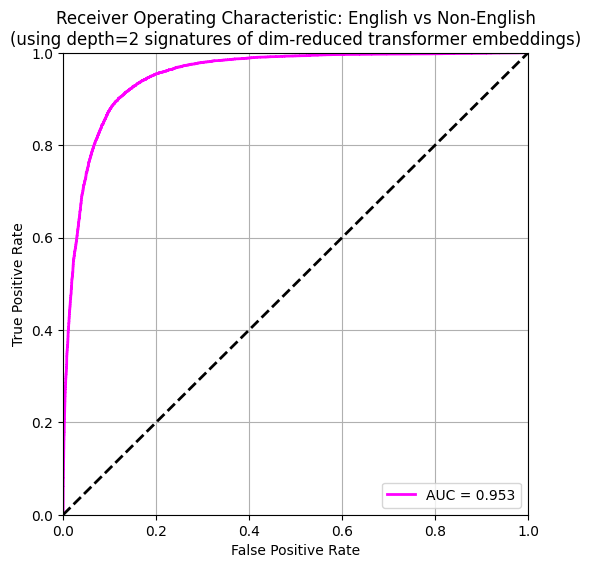

AUC: 0.953 +/- 0.001


In [66]:
auc, se = compute_auc_given_dists(
    scores_inliers,
    scores_outliers,
    bootstrap=True,
    bootstrap_samples=bootstrap_samples,
    random_state=seed,
    plot=True,
    title=(
        "English vs Non-English\n"
        f"(using depth={sig_depth} signatures of dim-reduced transformer embeddings)"
    ),
)

print(f"AUC: {auc:.3f} +/- {se:.3f}")

As noted above, in Section 5.2.4 of [[2]](https://arxiv.org/abs/2006.03487), we consider the same language dataset example as we do here and achieved an AUC score of $0.878$ +/- $0.002$, so we have achieved a boost in performance using our dimension-reduced transformer embeddings.

Looking at the CDF we can see there is good separation between the two classes:

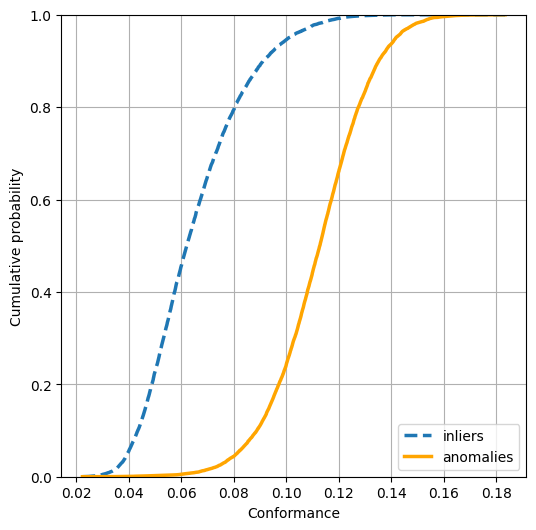

In [67]:
# plot CDF
plot_cdf_given_dists(
    scores_inliers,
    scores_outliers,
    bins=10000000,
    title=f"",
)

## Acknowledgements

The computations described in this notebook were performed using the Baskerville Tier 2 HPC service (https://www.baskerville.ac.uk/). Baskerville was funded by the EPSRC and UKRI through the World Class Labs scheme (EP/T022221/1) and the Digital Research Infrastructure programme (EP/W032244/1) and is operated by Advanced Research Computing at the University of Birmingham.

## References

[1] Devlin, J., Chang, M.W., Lee, K. and Toutanova, K., 2018. BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. _arXiv preprint arXiv:1810.04805_.

[2] Shao, Z., Chan, R.S.Y., Cochrane, T., Foster, P., Lyons, T. 2023. Dimensionless Anomaly Detection on Multivariate Streams with Variance Norm and Path Signature. _arXiv preprint arXiv:2006.03487_.

[3] Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., Levy, O., Lewis, M., Zettlemoyer, L. and Stoyanov, V., 2019. RoBERTa: A Robustly Optimized BERT Pretraining Approach. _arXiv preprint arXiv:1907.11692_.

[4] McInnes, L., and Healy, J. 2018. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, _arXiv preprint arXiv:1802.03426_.

[5] Tipping, M. E., and Bishop, C. M., 1999. Probabilistic Principal Component Analysis. _Journal of the Royal Statistical Society: Series B (Statistical Methodology)_, 61(3), 611-622.

[6] van der Maaten, L.J.P., and Hinton, G.E., 2008. Visualizing High-Dimensional Data using t-SNE. _Journal of Machine Learning Research_, 9:2579-2605.

[7] Mu, J., Bhat, S., and Viswanath, P. (2017). All-but-the-top: Simple and effective postprocessing for word representations. _arXiv preprint arXiv:1702.01417_.

[8] Raunak, V., Gupta, V., and Metze, F. (2019). Effective dimensionality reduction for word embeddings. In _Proceedings of the 4th Workshop on Representation Learning for NLP (RepL4NLP- 2019)_, 235–243.